<a href="https://colab.research.google.com/github/hansbrunner/safety_data/blob/main/Clozapine_adverse_events.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
In this analysis, I aim to explore the use of data analysis techniques within the field of drug safety surveillance.
Specifically, I am interested in understanding how adverse events related to medical drugs are reported and monitored.
This is a crucial area for ensuring the safety of medications, especially those used in complex treatment scenarios such as psychiatric and neurological conditions.

For this project, I have chosen to focus on Clozapine, an antipsychotic drug commonly used to treat schizophrenia.
Clozapine is known for its efficacy but also for its potential to cause a wide range of adverse events,
some of which can be severe.
The goal of this analysis is to gain insights into the types of adverse events reported for Clozapine and explore
trends in the data using information from the FDA Adverse Event Reporting System (FAERS), accessed via the OpenFDA API.

Throughout this analysis, I will focus on the following objectives:

Characterizing reported adverse events: Identifying the most commonly reported adverse events associated with Clozapine.
Demographic analysis: Examining whether certain demographic groups (age, gender) are more affected by specific adverse events.
Seriousness of events: Investigating the outcomes of reported adverse events, with a particular focus on serious outcomes such as hospitalization or death.
By working through this analysis, I hope to develop a deeper understanding of the real-world data related to drug safety and
enhance my skills in working with large datasets, especially those used in pharmacovigilance.
"""


In [78]:
import requests
import json

# API endpoint for OpenFDA drug adverse events
url = 'https://api.fda.gov/drug/event.json?search=clozapine&limit=1000' # start with 1000 reports

# Fetch the data
response = requests.get(url)
data = response.json()

# total reports in fda database
total_reports = data['meta']['results']['total']
print(f"Total number of reports available: {total_reports}")
# This is quite a lot, I will likely not collect all of them

# What information is there in a single report
first_entry = data['results'][0]

# Print the first entry
print(json.dumps(first_entry, indent=4))  # Pretty-print



Total number of reports available: 117512
{
    "safetyreportversion": "2",
    "safetyreportid": "10003635",
    "primarysourcecountry": "GB",
    "occurcountry": "GB",
    "transmissiondateformat": "102",
    "transmissiondate": "20151125",
    "reporttype": "1",
    "serious": "1",
    "seriousnesshospitalization": "1",
    "receivedateformat": "102",
    "receivedate": "20140312",
    "receiptdateformat": "102",
    "receiptdate": "20150819",
    "fulfillexpeditecriteria": "1",
    "companynumb": "PHFR2014GB002078",
    "duplicate": "1",
    "reportduplicate": {
        "duplicatesource": "NOVARTIS",
        "duplicatenumb": "PHFR2014GB002078"
    },
    "primarysource": {
        "reportercountry": "GB",
        "qualification": "1"
    },
    "sender": {
        "sendertype": "2",
        "senderorganization": "FDA-Public Use"
    },
    "receiver": {
        "receivertype": "6",
        "receiverorganization": "FDA"
    },
    "patient": {
        "patientonsetage": "46",
      

In [79]:
# If I want more than 1000 reports
import time
base_url = 'https://api.fda.gov/drug/event.json'
# Parameters for the API request
limit = 1000  # Fetch 1000 reports at a time
total_reports_to_fetch = 10000  # The total number of reports to getch
total_reports_fetched = 0  # Counter
data = []  # To store all fetched reports

# Loop to combine and fetch the data in chunks of 1000
while total_reports_fetched < total_reports_to_fetch:
    # Fetch the next batch of reports
    url = f'{base_url}?search=clozapine&limit={limit}&skip={total_reports_fetched}'
    response = requests.get(url)
    _data = response.json()

    # Add the fetched results to the all_data list
    data.extend(_data['results'])

    # Update the total number of reports fetched
    total_reports_fetched += len(_data['results'])

    # Sleep
    time.sleep(1)

In [80]:
# Print table of characteristics for reports (gender, age and outcome)
import pandas as pd
from collections import defaultdict
import numpy as np

outcome_labels = {
    '1': 'Recovered/Resolved',
    '2': 'Recovering/Resolving',
    '3': 'Not Recovered/Not Resolved',
    '4': 'Recovered/Resolved with Sequelae',
    '5': 'Fatal',
    '6': 'Unknown'
}

# Initialize dict
gender_counts = {'Male': 0, 'Female': 0, 'Unknown': 0}
age_counts = {
    'Less than 18': 0,
    '18-30': 0,
    '31-50': 0,
    '51-75': 0,
    'Above 75': 0,
    'Unknown': 0
}
outcome_counts = defaultdict(int)
total_reports = 0
# Extract data and fill dictionaries
for report in data:
    # Gender count
    patient = report['patient']

    # Get gender (1 = Male, 2 = Female, 3 = Unknown)
    gender = patient.get('patientsex', '3')  # Default to '3' (Unknown) if missing
    gender_label = 'Male' if gender == '1' else 'Female' if gender == '2' else 'Unknown'

    # Get age and categorize it
    age = patient.get('patientonsetage', None)
    age_unit = patient.get('patientonsetageunit', None)  # 801 = years
    if age and age_unit == '802':
      age = np.floor(int(age)/12).astype(int)
    if age:  # Only consider ages in years
        age = int(age)
        if age < 18:
            age_label = 'Less than 18'
        elif 18 <= age <= 30:
            age_label = '18-30'
        elif 31 <= age <= 50:
            age_label = '31-50'
        elif 51 <= age <= 75:
            age_label = '51-75'
        elif age > 75:
            age_label = 'Above 75'
    else:
        age_label = 'Unknown'

    # Outcome categorization (1-6)
    reactions = report['patient'].get('reaction', [])
    for reaction in reactions:
        outcome = reaction.get('reactionoutcome', '6')
        outcome_counts[outcome_labels[outcome]] += 1
        # fill gender and age
        gender_counts[gender_label] += 1
        age_counts[age_label] += 1

        # update counter
        total_reports += 1


def calculate_percentages(category_counts):
    return {key: (value, (value / total_reports) * 100) for key, value in category_counts.items()}
print(total_reports)

# dataframes
gender_df = pd.DataFrame.from_dict(calculate_percentages(gender_counts), orient='index', columns=['Count', 'Percentage'])
age_df = pd.DataFrame.from_dict(calculate_percentages(age_counts), orient='index', columns=['Count', 'Percentage'])
outcome_df = pd.DataFrame.from_dict(calculate_percentages(outcome_counts), orient='index', columns=['Count', 'Percentage'])
# reorder outcome table
outcome_df = outcome_df.reindex([
    'Recovered/Resolved',
    'Recovering/Resolving',
    'Not Recovered/Not Resolved',
    'Recovered/Resolved with Sequelae',
    'Fatal',
    'Unknown'
])

# Display the results as separate tables
print("Gender Distribution:")
print(gender_df)
print("\nAge Distribution:")
print(age_df)
print("\nOutcome Distribution:")
print(outcome_df)


34878
Gender Distribution:
         Count  Percentage
Male     20018   57.394346
Female   12156   34.852916
Unknown   2704    7.752738

Age Distribution:
              Count  Percentage
Less than 18    668    1.915247
18-30          3682   10.556798
31-50         10430   29.904238
51-75         10261   29.419691
Above 75       1093    3.133781
Unknown        8744   25.070245

Outcome Distribution:
                                  Count  Percentage
Recovered/Resolved                 7213   20.680658
Recovering/Resolving               2384    6.835254
Not Recovered/Not Resolved         4259   12.211136
Recovered/Resolved with Sequelae    125    0.358392
Fatal                              2811    8.059522
Unknown                           18086   51.855038


In [81]:
# Get number of adverse events and serious events
adverse_events = defaultdict(lambda: [0, 0])  # Each value is [total_count, severe_count]

# Define severe outcomes
severe_outcome_codes = {'4', '5'}  #  4 = Recovered with Sequelae, 5 = Fatal

# Loop data
for report in data:
    reactions = report['patient'].get('reaction', [])
    for reaction in reactions:
        event = reaction['reactionmeddrapt'] # preferred term
        outcome = reaction.get('reactionoutcome', '6')

        # Update count
        adverse_events[event][0] += 1  # Increment total count

        # Update severe count if the outcome is considered severe
        if outcome in severe_outcome_codes:
            adverse_events[event][1] += 1

# Convert to pandas dataframe
adverse_events_df = pd.DataFrame.from_dict(adverse_events, orient='index', columns=['Total Count', 'Severe Count'])

adverse_events_df = adverse_events_df.reset_index().rename(columns={'index': 'Adverse Event'})





In [82]:
# The adverse events are preferred terms, and not suited for further analysis - System Organ Classes would be better.
# Unfortunately, I do not have access to MedDra.
# Instead I will use Natural Language Processing (NLP) to map PT to SOC
# ChatGPT created the training dataset for NLP, I manually looked through it
import pandas as pd

# mapping of Preferred Terms (PTs) to System Organ Classes (SOCs) for 114 PTs by ChatGPT
pt_soc = {
    'PT': [
        'Endometrial cancer', 'Extrapyramidal disorder', 'Endotracheal intubation',
        'Electrocardiogram ST segment elevation', 'Subarachnoid haemorrhage',
        'Proteinuria', 'Blood alkaline phosphatase decreased', 'Asterixis',
        'Septic embolus', 'Obsessive-compulsive disorder', 'Thyroid cancer',
        'Abdominal discomfort', 'Tooth discolouration', 'Carcinoid syndrome',
        'Intervertebral discitis', 'White blood cell count abnormal', 'Paranoia',
        'Grip strength decreased', 'Acidosis', 'Splenic lesion',
        'Crying', 'Obstructive uropathy', 'Intestinal fistula', 'Cystic fibrosis',
        'Gasping syndrome', 'Educational problem', 'Enteral nutrition',
        'Product taste abnormal', 'Drug level above therapeutic',
        'Musculoskeletal stiffness', 'Diarrhoea', 'Ultrasound scan abnormal',
        'Myoglobin urine present', 'Metastatic carcinoma of the bladder',
        'Hepatic cancer recurrent', 'Mania', 'Oropharyngeal neoplasm',
        'Mediastinum neoplasm', 'Cataract', 'Arthritis infective',
        'Bundle branch block right', 'Lipids increased', 'Basophil count decreased',
        'Blood creatinine decreased', 'Trance', 'Electroencephalogram abnormal',
        'Prostatic specific antigen increased', 'Colonic pseudo-obstruction',
        'Grandiosity', 'Stereotypy', 'Hepatitis viral', 'Microalbuminuria',
        'Muscle contractions involuntary', 'Premenstrual pain',
        'Nicotine dependence', 'Illogical thinking', 'Spleen congestion',
        'Cross sensitivity reaction', 'Overweight', 'Muscle tightness', 'Stab wound',
        'Activated partial thromboplastin time abnormal', 'Kyphosis',
        'Nephrosclerosis', 'Shock', 'Dementia', 'Streptococcus test positive',
        'Tongue coated', 'Blood pressure orthostatic decreased',
        'Cerebral infarction', 'Creatine urine increased', 'Weight abnormal',
        'Gingival abscess', 'Toxicity to various agents',
        'Chronic myeloid leukaemia', 'Bladder cyst', 'Bladder mass',
        'Gastroenteritis norovirus', 'Aplasia pure red cell',
        'Cardiovascular disorder', 'Disability', 'Victim of crime',
        'N-terminal prohormone brain natriuretic peptide increased',
        'Cytomegalovirus infection', 'Pneumothorax', 'Duodenal ulcer perforation',
        'Injection site discolouration', 'Abdominal pain',
        'Ventricular tachycardia', 'Persecutory delusion', 'Amyloidosis', 'Abasia',
        'Granulocytopenia', 'Necrosis ischaemic', 'Hypophagia',
        'Enterocolitis infectious', 'Sarcoma', 'Metastatic neoplasm',
        'Cerebral ischaemia', 'General physical health deterioration',
        'Multiple organ dysfunction syndrome', 'Intestinal dilatation', 'Dystonia',
        'Mobility decreased', 'Mental retardation', 'Chest discomfort',
        'Schizophrenia, paranoid type', 'Hepatic failure', 'Screaming',
        'Hypertensive crisis', 'Embolic stroke', 'Sensation of foreign body',
        'Ketonuria', 'Purulent discharge'
    ],
    'SOC': [
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Endometrial cancer
        'Nervous system disorders',  # Extrapyramidal disorder
        'Respiratory, thoracic and mediastinal disorders',  # Endotracheal intubation
        'Cardiac disorders',  # Electrocardiogram ST segment elevation
        'Vascular disorders',  # Subarachnoid haemorrhage
        'Renal and urinary disorders',  # Proteinuria
        'Investigations',  # Blood alkaline phosphatase decreased
        'Nervous system disorders',  # Asterixis
        'Infections and infestations',  # Septic embolus
        'Psychiatric disorders',  # Obsessive-compulsive disorder
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Thyroid cancer
        'Gastrointestinal disorders',  # Abdominal discomfort
        'Gastrointestinal disorders',  # Tooth discolouration
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Carcinoid syndrome
        'Musculoskeletal and connective tissue disorders',  # Intervertebral discitis
        'Investigations',  # White blood cell count abnormal
        'Psychiatric disorders',  # Paranoia
        'Musculoskeletal and connective tissue disorders',  # Grip strength decreased
        'Metabolism and nutrition disorders',  # Acidosis
        'Hepatobiliary disorders',  # Splenic lesion
        'Psychiatric disorders',  # Crying
        'Renal and urinary disorders',  # Obstructive uropathy
        'Gastrointestinal disorders',  # Intestinal fistula
        'Respiratory, thoracic and mediastinal disorders',  # Cystic fibrosis
        'Respiratory, thoracic and mediastinal disorders',  # Gasping syndrome
        'Social circumstances',  # Educational problem
        'Gastrointestinal disorders',  # Enteral nutrition
        'General disorders and administration site conditions',  # Product taste abnormal
        'Investigations',  # Drug level above therapeutic
        'Musculoskeletal and connective tissue disorders',  # Musculoskeletal stiffness
        'Gastrointestinal disorders',  # Diarrhoea
        'Investigations',  # Ultrasound scan abnormal
        'Renal and urinary disorders',  # Myoglobin urine present
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Metastatic carcinoma of the bladder
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Hepatic cancer recurrent
        'Psychiatric disorders',  # Mania
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Oropharyngeal neoplasm
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Mediastinum neoplasm
        'Eye disorders',  # Cataract
        'Musculoskeletal and connective tissue disorders',  # Arthritis infective
        'Cardiac disorders',  # Bundle branch block right
        'Metabolism and nutrition disorders',  # Lipids increased
        'Investigations',  # Basophil count decreased
        'Investigations',  # Blood creatinine decreased
        'Psychiatric disorders',  # Trance
        'Investigations',  # Electroencephalogram abnormal
        'Investigations',  # Prostatic specific antigen increased
        'Gastrointestinal disorders',  # Colonic pseudo-obstruction
        'Psychiatric disorders',  # Grandiosity
        'Psychiatric disorders',  # Stereotypy
        'Infections and infestations',  # Hepatitis viral
        'Renal and urinary disorders',  # Microalbuminuria
        'Nervous system disorders',  # Muscle contractions involuntary
        'Reproductive system and breast disorders',  # Premenstrual pain
        'Psychiatric disorders',  # Nicotine dependence
        'Psychiatric disorders',  # Illogical thinking
        'Hepatobiliary disorders',  # Spleen congestion
        'Immune system disorders',  # Cross sensitivity reaction
        'Metabolism and nutrition disorders',  # Overweight
        'Musculoskeletal and connective tissue disorders',  # Muscle tightness
        'Injury, poisoning and procedural complications',  # Stab wound
        'Investigations',  # Activated partial thromboplastin time abnormal
        'Musculoskeletal and connective tissue disorders',  # Kyphosis
        'Renal and urinary disorders',  # Nephrosclerosis
        'General disorders and administration site conditions',  # Shock
        'Nervous system disorders',  # Dementia
        'Infections and infestations',  # Streptococcus test positive
        'Gastrointestinal disorders',  # Tongue coated
        'Vascular disorders',  # Blood pressure orthostatic decreased
        'Nervous system disorders',  # Cerebral infarction
        'Investigations',  # Creatine urine increased
        'Metabolism and nutrition disorders',  # Weight abnormal
        'Infections and infestations',  # Gingival abscess
        'Injury, poisoning and procedural complications',  # Toxicity to various agents
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Chronic myeloid leukaemia
        'Renal and urinary disorders',  # Bladder cyst
        'Renal and urinary disorders',  # Bladder mass
        'Infections and infestations',  # Gastroenteritis norovirus
        'Blood and lymphatic system disorders',  # Aplasia pure red cell
        'Cardiac disorders',  # Cardiovascular disorder
        'General disorders and administration site conditions',  # Disability
        'Social circumstances',  # Victim of crime
        'Investigations',  # N-terminal prohormone brain natriuretic peptide increased
        'Infections and infestations',  # Cytomegalovirus infection
        'Respiratory, thoracic and mediastinal disorders',  # Pneumothorax
        'Gastrointestinal disorders',  # Duodenal ulcer perforation
        'Injury, poisoning and procedural complications',  # Injection site discolouration
        'Gastrointestinal disorders',  # Abdominal pain
        'Cardiac disorders',  # Ventricular tachycardia
        'Psychiatric disorders',  # Persecutory delusion
        'Metabolism and nutrition disorders',  # Amyloidosis
        'Nervous system disorders',  # Abasia
        'Blood and lymphatic system disorders',  # Granulocytopenia
        'Injury, poisoning and procedural complications',  # Necrosis ischaemic
        'Gastrointestinal disorders',  # Hypophagia
        'Infections and infestations',  # Enterocolitis infectious
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Sarcoma
        'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',  # Metastatic neoplasm
        'Nervous system disorders',  # Cerebral ischaemia
        'General disorders and administration site conditions',  # General physical health deterioration
        'General disorders and administration site conditions',  # Multiple organ dysfunction syndrome
        'Gastrointestinal disorders',  # Intestinal dilatation
        'Nervous system disorders',  # Dystonia
        'Musculoskeletal and connective tissue disorders',  # Mobility decreased
        'Psychiatric disorders',  # Mental retardation
        'Cardiac disorders',  # Chest discomfort
        'Psychiatric disorders',  # Schizophrenia, paranoid type
        'Hepatobiliary disorders',  # Hepatic failure
        'Psychiatric disorders',  # Screaming
        'Vascular disorders',  # Hypertensive crisis
        'Vascular disorders',  # Embolic stroke
        'General disorders and administration site conditions',  # Sensation of foreign body
        'Metabolism and nutrition disorders',  # Ketonuria
        'Infections and infestations'  # Purulent discharge
    ]
}

# Create the pandas DataFrame
df = pd.DataFrame.from_dict(pt_soc)


In [83]:
# Barplot of common adverse events (2% cutoff)

cut_off = adverse_events_df['Total Count'].sum()*.002

common_adverse_event_df = adverse_events_df.loc[adverse_events_df['Total Count']>cut_off,:]
print(common_adverse_event_df.head())


                      Adverse Event  Total Count  Severe Count
0        Neutrophil count increased         1007             4
1  White blood cell count increased         1341             4
2                Abnormal behaviour          138             3
5                       Tachycardia          261             0
6                  Granulocytopenia          502             1


In [ ]:
# NLP

In [84]:
# Redo this part with SOC
# Count reported adverse events
# Extract adverse events (Preferred Terms)
from collections import Counter

adverse_events = []

for report in data:
    reactions = report['patient'].get('reaction', [])
    for reaction in reactions:
        adverse_events.append(reaction['reactionmeddrapt'])

# Count the frequency of each adverse event (Preferred Term)
event_counts = Counter(adverse_events)

# Display the most common adverse events
print("Most Common Adverse Events (Preferred Terms):")
for event, count in event_counts.most_common(10):  # Show top 10 most common events
    print(f"{event}: {count}")

Most Common Adverse Events (Preferred Terms):
White blood cell count increased: 1341
Neutrophil count increased: 1007
Death: 904
White blood cell count decreased: 595
Neutropenia: 545
Neutrophil count decreased: 513
Granulocytopenia: 502
Schizophrenia: 369
Pneumonia: 363
Malaise: 354


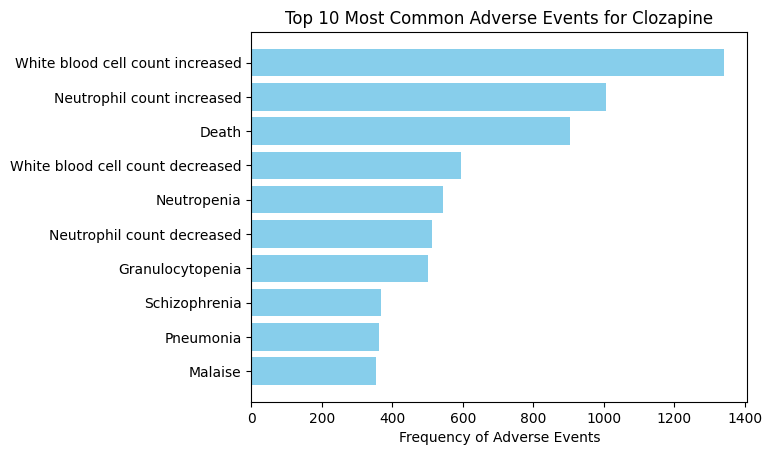

In [85]:
# plot # reports for adverse events
# Extract the top 10 most common adverse events
import matplotlib.pyplot as plt
top_events = event_counts.most_common(10)
events, counts = zip(*top_events)

# Plot a bar chart for the counts of adverse events
plt.figure()
plt.barh(events, counts, color='skyblue')
plt.xlabel('Frequency of Adverse Events')
plt.title('Top 10 Most Common Adverse Events for Clozapine')
plt.gca().invert_yaxis()  # Highest frequency at the top
plt.show()

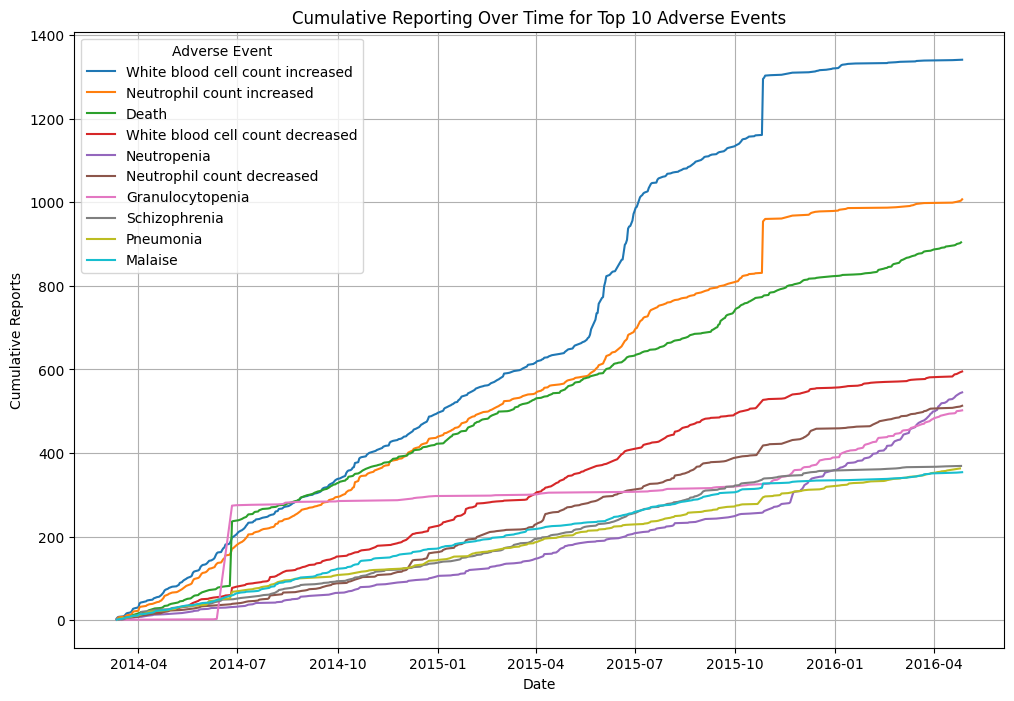

In [86]:
# plot adverse event reporting over time
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Adverse events and report dates
event_report_dates = defaultdict(list)

for report in data:
    received_date = report.get('receivedate', None)
    if received_date:
        # Convert the date string (YYYYMMDD) into a datetime object
        report_date = datetime.strptime(received_date, '%Y%m%d')

        # Extract the reported adverse events (reactions)
        reactions = report['patient'].get('reaction', [])
        for reaction in reactions:
            event_report_dates[reaction['reactionmeddrapt']].append(report_date)

# Frequency of each adverse event
event_counts = Counter({event: len(dates) for event, dates in event_report_dates.items()})

# Get the top 10 most common adverse events
top_10_events = event_counts.most_common(10)

# Plot cumulative reporting over time for each of the top 10 adverse events
plt.figure(figsize=(12, 8))

for event, _ in top_10_events:
    # Convert the dates list to a DataFrame for cumulative counting
    dates = event_report_dates[event]
    df = pd.DataFrame(dates, columns=['date'])
    df['count'] = 1

    # Group by date and calculate the cumulative sum of reports
    df = df.groupby('date').count().cumsum().reset_index()

    # Normalize the cumulative sum
    df['normalized_count'] = df['count'] / df['count'].max()

    # Plot cumulative reporting over time for this adverse event
    plt.plot(df['date'], df['count'], label=event)

# Tidy plot
plt.title('Cumulative Reporting Over Time for Top 10 Adverse Events')
plt.xlabel('Date')
plt.ylabel('Cumulative Reports')
plt.legend(title='Adverse Event')
plt.grid(True)
plt.show()
